In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('toi_2010_18.csv')

In [3]:
data.head()

,DATE,AUTHOR,IMAGE,TEXT,KEYWORDS,SUMMARY
0,8-1-2010,[],https://static.toiimg.com/photo/msid-5423538/5...,"Junali Devi, a widow living in Assam, is eager...","['hivaids', 'hiv', 'website', 'positive', 'spe...","Junali Devi, a widow living in Assam, is eager..."
1,11-1-2010,['Karthika Gopalakrishnan'],https://static.toiimg.com/photo/msid-47529300/...,CHENNAI: Researchers working towards a cure fo...,"['hiv', 'schooley', 'hopeful', 'research', 're...",These cells have a second molecule called CCR5...
2,12-1-2010,[],https://static.toiimg.com/photo/msid-47529300/...,LUCKNOW: After running from the pillar to post...,"['hiv', 'ngos', 'money', 'shelter', 'poonam', ...",The hapless woman was thrown out by her husban...
3,30-1-2010,[],https://static.toiimg.com/photo/msid-47529300/...,"BANGALORE: Nutrition, education and property r...","['hivaids', 'hiv', 'positive', 'aids', 'childr...","BANGALORE: Nutrition, education and property r..."
4,1-2-2010,['Kounteya Sinha'],https://static.toiimg.com/photo/msid-47529300/...,NEW DELHI: A vaccine to protect HIV patients f...,"['hiv', 'mv', 'aids', 'tb', 'hivinfected', 'pa...",NEW DELHI: A vaccine to protect HIV patients f...


In [4]:
corpus = data['TEXT']

In [5]:
# load nltk's English stopwords as variable called 'stopwords'
#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [8]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in corpus:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [9]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 429437 items in vocab_frame


# TFIDF 

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(corpus) #fit the vectorizer to synopses

print(tfidf_matrix.shape)


CPU times: user 11.9 s, sys: 64 ms, total: 11.9 s
Wall time: 11.9 s
(1228, 79)


In [11]:
terms = tfidf_vectorizer.get_feature_names()

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)


# K-means Clustering

In [13]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 2.92 s, sys: 4 ms, total: 2.92 s
Wall time: 2.93 s


In [14]:
'''from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

#joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()'''

"from sklearn.externals import joblib\n\n#uncomment the below to save your model \n#since I've already run my model I am loading from the pickle\n\n#joblib.dump(km,  'doc_cluster.pkl')\n\nkm = joblib.load('doc_cluster.pkl')\nclusters = km.labels_.tolist()"

In [15]:
data['clusters'] = clusters

In [16]:
ID = str(list(range(0, 1228)))
data['ID'] = ID

In [17]:
data['clusters'].value_counts()

3    416
0    324
4    240
1    134
2    114
Name: clusters, dtype: int64

In [18]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    
    print('\n')
    print("Cluster %d:" % i)    
    print('\n')
    
    for ind in order_centroids[i, :10]:
        print( '%s' % terms[ind])



Cluster 0:


test
posit
hiv posit
's
peopl
case
district
women
year
hospit


Cluster 1:


children
live
posit
hiv posit
state
care
govern
's
district
year


Cluster 2:


blood
test
hospit
infect
case
virus
report
patient
govern
's


Cluster 3:


infect
peopl
aid
state
virus
drug
new
health
india
use


Cluster 4:


patient
hospit
art
centr
treatment
doctor
medic
dr
posit
drug


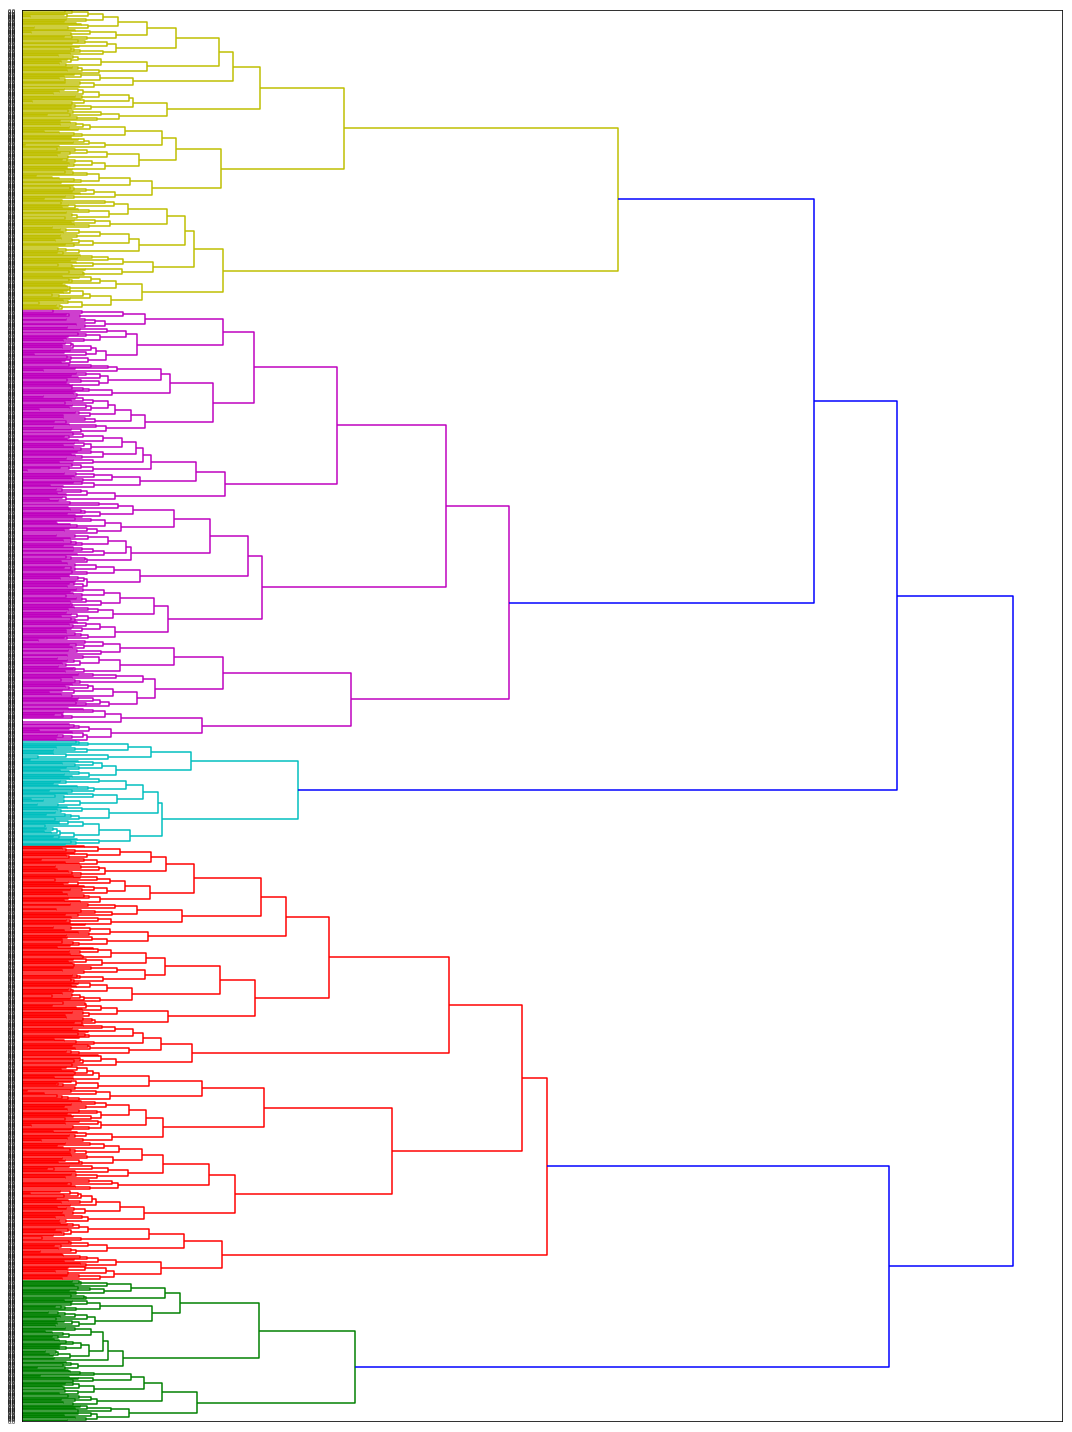

In [26]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=np.zeros(len(corpus)))

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.savefig('ward_clusters.png', dpi=200)
plt.tight_layout() #show plot with tight layout
#plt.show()
#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_cluster

# Latent Dirichlet Allocation¶

In [28]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [29]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [30]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in corpus]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 4.84 s, sys: 28 ms, total: 4.87 s
Wall time: 4.93 s
CPU times: user 6.96 s, sys: 88 ms, total: 7.04 s
Wall time: 7.13 s
CPU times: user 728 ms, sys: 8 ms, total: 736 ms
Wall time: 739 ms


In [31]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus_bow = [dictionary.doc2bow(text) for text in texts]

In [34]:
%time lda = models.LdaModel(corpus_bow, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 3min 9s, sys: 16 ms, total: 3min 9s
Wall time: 3min 9s


In [35]:
lda.show_topics()

[(0,
  '0.017*"hospit" + 0.016*"patient" + 0.010*"posit" + 0.009*"woman" + 0.009*"doctor" + 0.009*"medic" + 0.009*"\'s" + 0.008*"polic" + 0.007*"famili" + 0.007*"husband"'),
 (1,
  '0.020*"peopl" + 0.019*"test" + 0.015*"posit" + 0.013*"centr" + 0.012*"state" + 0.011*"patient" + 0.010*"case" + 0.010*"district" + 0.009*"number" + 0.009*"health"'),
 (2,
  '0.029*"children" + 0.026*"blood" + 0.013*"test" + 0.012*"school" + 0.011*"child" + 0.011*"infect" + 0.010*"posit" + 0.010*"mother" + 0.010*"parent" + 0.008*"transfus"'),
 (3,
  '0.019*"infect" + 0.015*"virus" + 0.015*"patient" + 0.015*"drug" + 0.010*"treatment" + 0.008*"new" + 0.008*"studi" + 0.007*"cell" + 0.007*"use" + 0.006*"peopl"'),
 (4,
  '0.028*"sex" + 0.019*"among" + 0.016*"worker" + 0.015*"preval" + 0.014*"men" + 0.012*"state" + 0.012*"high" + 0.011*"year" + 0.008*"sexual" + 0.008*"infect"')]

In [52]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
'''topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()'''

#for i in range

'topics_matrix = np.array(topics_matrix)\n\ntopic_words = topics_matrix[:,:,1]\nfor i in topic_words:\n    print([str(word) for word in i])\n    print()'

In [54]:
topics_matrix

[(0,
  [('hospit', 0.01672098),
   ('patient', 0.01566928),
   ('posit', 0.010242492),
   ('woman', 0.009367754),
   ('doctor', 0.009104535),
   ('medic', 0.009065249),
   ("'s", 0.008623805),
   ('polic', 0.008275199),
   ('famili', 0.0070295325),
   ('husband', 0.0068002935),
   ('test', 0.0061585666),
   ('treatment', 0.0061373697),
   ('also', 0.005716172),
   ('report', 0.00563402),
   ('told', 0.005519625),
   ('alleg', 0.005346895),
   ('ask', 0.0049371943),
   ('case', 0.004911922),
   ('would', 0.004845531),
   ('two', 0.0048310827)]),
 (1,
  [('peopl', 0.020363407),
   ('test', 0.01892579),
   ('posit', 0.015246991),
   ('centr', 0.012578322),
   ('state', 0.012078756),
   ('patient', 0.0110293375),
   ('case', 0.0101225),
   ('district', 0.009700607),
   ('number', 0.0093120225),
   ('health', 0.009074151),
   ('also', 0.00895092),
   ('year', 0.008839393),
   ('govern', 0.0080328435),
   ('women', 0.0075533874),
   ('infect', 0.007291588),
   ('awar', 0.0072338944),
   ('li